In [1]:
from datetime import date, datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import ARDRegression

In [2]:
data = pd.read_csv('../data/men_velodata2.csv')
data['day'].replace(0, 1, inplace = True)
data.insert(
    4, 'date', [
        date(year = int(data.loc[i, 'year']), month = int(data.loc[i, 'month']), day = int(data.loc[i, 'day']))
        for i in data.index
    ]
)
data.drop(columns = ['year', 'month', 'day'], inplace = True)
data.head(5)

,name,stage,points_scale,parcours_type,date,type,length,profile_score,avg_speed,vertical_meters,won_how,place,rider,team,age,time
0,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,1.0,ALAPHILIPPE Julian,Deceuninck - Quick Step,29.0,0.0
1,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,2.0,MATTHEWS Michael,Team BikeExchange,30.0,8.0
2,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,3.0,ROGLIČ Primož,Team Jumbo-Visma,31.0,8.0
3,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,4.0,HAIG Jack,Bahrain - Victorious,27.0,8.0
4,tour-de-france,stage-1,GT.A.Stage,p3,2021-06-26,standard,197.8,109.0,42.525 km/h,2843.0,2.2 km solo,5.0,KELDERMAN Wilco,BORA - hansgrohe,30.0,8.0


In [3]:
def get_rider_data(data, rider):
    
    rider_data = data[data['rider'] == rider].sort_values(by = 'date').reset_index(drop = True)
    return rider_data

In [4]:
def mvavg(seq, window = 5):
    return [
        np.mean(seq[i - window: i])
        for i in range(window, len(seq))
    ]

def auto(seq, window = 5):
    
    X = [
        seq[i - window: i]
        for i in range(window, len(seq))
    ]
    y = list(seq[window: ])
    
    model = ARDRegression()
    model.fit(X, y)
    
    return model.predict(X)

In [5]:
def plot_rider_results(data, name, window = 12):
    
    athlete_data = get_rider_data(data, name)
    x = athlete_data['date']
    y = athlete_data['place']
    
    
    fig, ax = plt.subplots(figsize = (16, 12))
    ax.scatter(x, y, color = 'black')
    ax.scatter(x[window: ], auto(y, window = window), color = 'blue')
    ax.invert_yaxis()

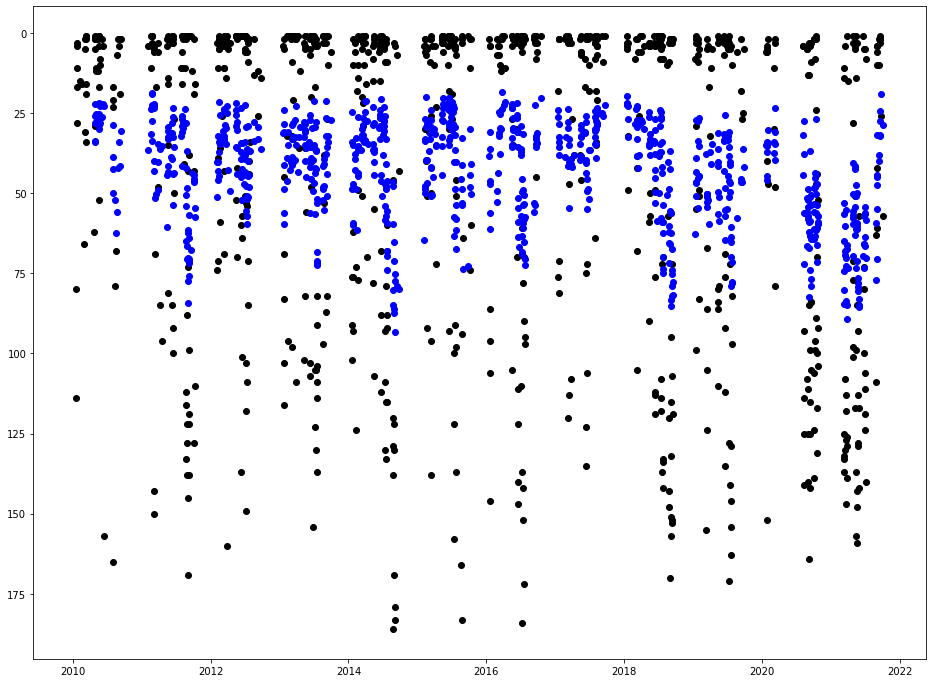

In [6]:
plot_rider_results(data, 'SAGAN Peter', window = 20)

In [7]:
def get_rider_career_results(data, rider, curr_year, race_types = ['standard', 'one-day-race']):
    """
    For preliminary win probability generation work. Get rider's historical results, but aggregated, without
    regard for sequentiality. Data is collected up to, but not including, the current year.
    """
    
    rider_data = get_rider_data(data, rider)
    
    # exclude the current year
    rider_data = rider_data[rider_data['date'] < date(year = curr_year, month = 1, day = 1)]
    
    # isolate the given race_types
    rider_data = rider_data[rider_data['type'].isin(race_types)].reset_index(drop = True)
    
    # establish fields to collect
    race_classes = [
        'GT.A.Stage', 'Worlds.RR', 'Olympics.RR', '1.WT.A',
        '2.WT.Stage', '1.WT.B', 'GT.B.Stage', '1.PRO',
        '2.PRO.Stage', '2.1.Stage',
        'Nationals.C3', '1.1',
        '1.2', '2.2.Stage',
        'Nationals.C1'
    ]
    
    fields = []
    parcours_types = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']
    place_cats = [1, 3, 10]
    for pt in parcours_types:
        for clss in race_classes:
            for place in place_cats:
                fields.append(f'career_{pt}_{clss}_top{place}')
    
    fields += [f + '_prev_yr' for f in fields]
    
    # init dict to collect data
    rider_dict = {field: 0 for field in fields}
    
    # iterate through rider's results and populate rider dict
    for i in rider_data.index:
        
        points_scale = rider_data.loc[i, 'points_scale']
        if points_scale not in race_classes:
            continue
        
        parcours_type = rider_data.loc[i, 'parcours_type']
        result = rider_data.loc[i, 'place']
        year = rider_data.loc[i, 'date'].year
        
        for place in place_cats:
            
            if result <= place:
                rider_dict[f'career_{parcours_type}_{points_scale}_top{place}'] += 1
                if year == curr_year - 1:
                    rider_dict[f'career_{parcours_type}_{points_scale}_top{place}_prev_yr'] += 1
        
    return rider_dict

def get_rider_season_results(data, rider, race_date, race_types = ['standard', 'one-day-race']):
    
    rider_data = get_rider_data(data, rider)
    
    # include only the current year
    rider_data = rider_data[rider_data['date'] >= date(year = race_date.year, month = 1, day = 1)]
    rider_data = rider_data[rider_data['date'] < race_date]
    
    # isolate the given race_types
    rider_data = rider_data[rider_data['type'].isin(race_types)].reset_index(drop = True)
    
    # establish fields to collect
    race_classes = [
        'GT.A.Stage', 'Worlds.RR', 'Olympics.RR', '1.WT.A',
        '2.WT.Stage', '1.WT.B', 'GT.B.Stage', '1.PRO',
        '2.PRO.Stage', '2.1.Stage',
        'Nationals.C3', '1.1',
        '1.2', '2.2.Stage',
        'Nationals.C1'
    ]
    
    fields = []
    parcours_types = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']
    place_cats = [1, 3, 10]
    for pt in parcours_types:
        for clss in race_classes:
            for place in place_cats:
                fields.append(f'season_{pt}_{clss}_top{place}')
    fields.append('season_race_days')
    
    # init dict to collect data
    rider_dict = {field: 0 for field in fields}
    
    # iterate through rider's results and populate rider dict
    for i in rider_data.index:
        
        points_scale = rider_data.loc[i, 'points_scale']
        if points_scale not in race_classes:
            continue
        
        parcours_type = rider_data.loc[i, 'parcours_type']
        result = rider_data.loc[i, 'place']
        year = rider_data.loc[i, 'date'].year
        
        for place in place_cats:
            
            if result <= place:
                rider_dict[f'season_{parcours_type}_{points_scale}_top{place}'] += 1
        
        rider_dict['season_race_days'] += 1
        
    return rider_dict

In [8]:
def create_one_day_results_data(manager_dict, idx, data, year, show_tqdm = False):
    
    data = data.reset_index(drop = True)
    
    season_fields = ['season_p0_GT.A.Stage_top1', 'season_p0_GT.A.Stage_top3', 'season_p0_GT.A.Stage_top10', 'season_p0_Worlds.RR_top1', 'season_p0_Worlds.RR_top3', 'season_p0_Worlds.RR_top10', 'season_p0_Olympics.RR_top1', 'season_p0_Olympics.RR_top3', 'season_p0_Olympics.RR_top10', 'season_p0_1.WT.A_top1', 'season_p0_1.WT.A_top3', 'season_p0_1.WT.A_top10', 'season_p0_2.WT.Stage_top1', 'season_p0_2.WT.Stage_top3', 'season_p0_2.WT.Stage_top10', 'season_p0_1.WT.B_top1', 'season_p0_1.WT.B_top3', 'season_p0_1.WT.B_top10', 'season_p0_GT.B.Stage_top1', 'season_p0_GT.B.Stage_top3', 'season_p0_GT.B.Stage_top10', 'season_p0_1.PRO_top1', 'season_p0_1.PRO_top3', 'season_p0_1.PRO_top10', 'season_p0_2.PRO.Stage_top1', 'season_p0_2.PRO.Stage_top3', 'season_p0_2.PRO.Stage_top10', 'season_p0_2.1.Stage_top1', 'season_p0_2.1.Stage_top3', 'season_p0_2.1.Stage_top10', 'season_p0_Nationals.C3_top1', 'season_p0_Nationals.C3_top3', 'season_p0_Nationals.C3_top10', 'season_p0_1.1_top1', 'season_p0_1.1_top3', 'season_p0_1.1_top10', 'season_p0_1.2_top1', 'season_p0_1.2_top3', 'season_p0_1.2_top10', 'season_p0_2.2.Stage_top1', 'season_p0_2.2.Stage_top3', 'season_p0_2.2.Stage_top10', 'season_p0_Nationals.C1_top1', 'season_p0_Nationals.C1_top3', 'season_p0_Nationals.C1_top10', 'season_p1_GT.A.Stage_top1', 'season_p1_GT.A.Stage_top3', 'season_p1_GT.A.Stage_top10', 'season_p1_Worlds.RR_top1', 'season_p1_Worlds.RR_top3', 'season_p1_Worlds.RR_top10', 'season_p1_Olympics.RR_top1', 'season_p1_Olympics.RR_top3', 'season_p1_Olympics.RR_top10', 'season_p1_1.WT.A_top1', 'season_p1_1.WT.A_top3', 'season_p1_1.WT.A_top10', 'season_p1_2.WT.Stage_top1', 'season_p1_2.WT.Stage_top3', 'season_p1_2.WT.Stage_top10', 'season_p1_1.WT.B_top1', 'season_p1_1.WT.B_top3', 'season_p1_1.WT.B_top10', 'season_p1_GT.B.Stage_top1', 'season_p1_GT.B.Stage_top3', 'season_p1_GT.B.Stage_top10', 'season_p1_1.PRO_top1', 'season_p1_1.PRO_top3', 'season_p1_1.PRO_top10', 'season_p1_2.PRO.Stage_top1', 'season_p1_2.PRO.Stage_top3', 'season_p1_2.PRO.Stage_top10', 'season_p1_2.1.Stage_top1', 'season_p1_2.1.Stage_top3', 'season_p1_2.1.Stage_top10', 'season_p1_Nationals.C3_top1', 'season_p1_Nationals.C3_top3', 'season_p1_Nationals.C3_top10', 'season_p1_1.1_top1', 'season_p1_1.1_top3', 'season_p1_1.1_top10', 'season_p1_1.2_top1', 'season_p1_1.2_top3', 'season_p1_1.2_top10', 'season_p1_2.2.Stage_top1', 'season_p1_2.2.Stage_top3', 'season_p1_2.2.Stage_top10', 'season_p1_Nationals.C1_top1', 'season_p1_Nationals.C1_top3', 'season_p1_Nationals.C1_top10', 'season_p2_GT.A.Stage_top1', 'season_p2_GT.A.Stage_top3', 'season_p2_GT.A.Stage_top10', 'season_p2_Worlds.RR_top1', 'season_p2_Worlds.RR_top3', 'season_p2_Worlds.RR_top10', 'season_p2_Olympics.RR_top1', 'season_p2_Olympics.RR_top3', 'season_p2_Olympics.RR_top10', 'season_p2_1.WT.A_top1', 'season_p2_1.WT.A_top3', 'season_p2_1.WT.A_top10', 'season_p2_2.WT.Stage_top1', 'season_p2_2.WT.Stage_top3', 'season_p2_2.WT.Stage_top10', 'season_p2_1.WT.B_top1', 'season_p2_1.WT.B_top3', 'season_p2_1.WT.B_top10', 'season_p2_GT.B.Stage_top1', 'season_p2_GT.B.Stage_top3', 'season_p2_GT.B.Stage_top10', 'season_p2_1.PRO_top1', 'season_p2_1.PRO_top3', 'season_p2_1.PRO_top10', 'season_p2_2.PRO.Stage_top1', 'season_p2_2.PRO.Stage_top3', 'season_p2_2.PRO.Stage_top10', 'season_p2_2.1.Stage_top1', 'season_p2_2.1.Stage_top3', 'season_p2_2.1.Stage_top10', 'season_p2_Nationals.C3_top1', 'season_p2_Nationals.C3_top3', 'season_p2_Nationals.C3_top10', 'season_p2_1.1_top1', 'season_p2_1.1_top3', 'season_p2_1.1_top10', 'season_p2_1.2_top1', 'season_p2_1.2_top3', 'season_p2_1.2_top10', 'season_p2_2.2.Stage_top1', 'season_p2_2.2.Stage_top3', 'season_p2_2.2.Stage_top10', 'season_p2_Nationals.C1_top1', 'season_p2_Nationals.C1_top3', 'season_p2_Nationals.C1_top10', 'season_p3_GT.A.Stage_top1', 'season_p3_GT.A.Stage_top3', 'season_p3_GT.A.Stage_top10', 'season_p3_Worlds.RR_top1', 'season_p3_Worlds.RR_top3', 'season_p3_Worlds.RR_top10', 'season_p3_Olympics.RR_top1', 'season_p3_Olympics.RR_top3', 'season_p3_Olympics.RR_top10', 'season_p3_1.WT.A_top1', 'season_p3_1.WT.A_top3', 'season_p3_1.WT.A_top10', 'season_p3_2.WT.Stage_top1', 'season_p3_2.WT.Stage_top3', 'season_p3_2.WT.Stage_top10', 'season_p3_1.WT.B_top1', 'season_p3_1.WT.B_top3', 'season_p3_1.WT.B_top10', 'season_p3_GT.B.Stage_top1', 'season_p3_GT.B.Stage_top3', 'season_p3_GT.B.Stage_top10', 'season_p3_1.PRO_top1', 'season_p3_1.PRO_top3', 'season_p3_1.PRO_top10', 'season_p3_2.PRO.Stage_top1', 'season_p3_2.PRO.Stage_top3', 'season_p3_2.PRO.Stage_top10', 'season_p3_2.1.Stage_top1', 'season_p3_2.1.Stage_top3', 'season_p3_2.1.Stage_top10', 'season_p3_Nationals.C3_top1', 'season_p3_Nationals.C3_top3', 'season_p3_Nationals.C3_top10', 'season_p3_1.1_top1', 'season_p3_1.1_top3', 'season_p3_1.1_top10', 'season_p3_1.2_top1', 'season_p3_1.2_top3', 'season_p3_1.2_top10', 'season_p3_2.2.Stage_top1', 'season_p3_2.2.Stage_top3', 'season_p3_2.2.Stage_top10', 'season_p3_Nationals.C1_top1', 'season_p3_Nationals.C1_top3', 'season_p3_Nationals.C1_top10', 'season_p4_GT.A.Stage_top1', 'season_p4_GT.A.Stage_top3', 'season_p4_GT.A.Stage_top10', 'season_p4_Worlds.RR_top1', 'season_p4_Worlds.RR_top3', 'season_p4_Worlds.RR_top10', 'season_p4_Olympics.RR_top1', 'season_p4_Olympics.RR_top3', 'season_p4_Olympics.RR_top10', 'season_p4_1.WT.A_top1', 'season_p4_1.WT.A_top3', 'season_p4_1.WT.A_top10', 'season_p4_2.WT.Stage_top1', 'season_p4_2.WT.Stage_top3', 'season_p4_2.WT.Stage_top10', 'season_p4_1.WT.B_top1', 'season_p4_1.WT.B_top3', 'season_p4_1.WT.B_top10', 'season_p4_GT.B.Stage_top1', 'season_p4_GT.B.Stage_top3', 'season_p4_GT.B.Stage_top10', 'season_p4_1.PRO_top1', 'season_p4_1.PRO_top3', 'season_p4_1.PRO_top10', 'season_p4_2.PRO.Stage_top1', 'season_p4_2.PRO.Stage_top3', 'season_p4_2.PRO.Stage_top10', 'season_p4_2.1.Stage_top1', 'season_p4_2.1.Stage_top3', 'season_p4_2.1.Stage_top10', 'season_p4_Nationals.C3_top1', 'season_p4_Nationals.C3_top3', 'season_p4_Nationals.C3_top10', 'season_p4_1.1_top1', 'season_p4_1.1_top3', 'season_p4_1.1_top10', 'season_p4_1.2_top1', 'season_p4_1.2_top3', 'season_p4_1.2_top10', 'season_p4_2.2.Stage_top1', 'season_p4_2.2.Stage_top3', 'season_p4_2.2.Stage_top10', 'season_p4_Nationals.C1_top1', 'season_p4_Nationals.C1_top3', 'season_p4_Nationals.C1_top10', 'season_p5_GT.A.Stage_top1', 'season_p5_GT.A.Stage_top3', 'season_p5_GT.A.Stage_top10', 'season_p5_Worlds.RR_top1', 'season_p5_Worlds.RR_top3', 'season_p5_Worlds.RR_top10', 'season_p5_Olympics.RR_top1', 'season_p5_Olympics.RR_top3', 'season_p5_Olympics.RR_top10', 'season_p5_1.WT.A_top1', 'season_p5_1.WT.A_top3', 'season_p5_1.WT.A_top10', 'season_p5_2.WT.Stage_top1', 'season_p5_2.WT.Stage_top3', 'season_p5_2.WT.Stage_top10', 'season_p5_1.WT.B_top1', 'season_p5_1.WT.B_top3', 'season_p5_1.WT.B_top10', 'season_p5_GT.B.Stage_top1', 'season_p5_GT.B.Stage_top3', 'season_p5_GT.B.Stage_top10', 'season_p5_1.PRO_top1', 'season_p5_1.PRO_top3', 'season_p5_1.PRO_top10', 'season_p5_2.PRO.Stage_top1', 'season_p5_2.PRO.Stage_top3', 'season_p5_2.PRO.Stage_top10', 'season_p5_2.1.Stage_top1', 'season_p5_2.1.Stage_top3', 'season_p5_2.1.Stage_top10', 'season_p5_Nationals.C3_top1', 'season_p5_Nationals.C3_top3', 'season_p5_Nationals.C3_top10', 'season_p5_1.1_top1', 'season_p5_1.1_top3', 'season_p5_1.1_top10', 'season_p5_1.2_top1', 'season_p5_1.2_top3', 'season_p5_1.2_top10', 'season_p5_2.2.Stage_top1', 'season_p5_2.2.Stage_top3', 'season_p5_2.2.Stage_top10', 'season_p5_Nationals.C1_top1', 'season_p5_Nationals.C1_top3', 'season_p5_Nationals.C1_top10', 'season_race_days']
    career_fields = ['career_p0_GT.A.Stage_top1', 'career_p0_GT.A.Stage_top3', 'career_p0_GT.A.Stage_top10', 'career_p0_Worlds.RR_top1', 'career_p0_Worlds.RR_top3', 'career_p0_Worlds.RR_top10', 'career_p0_Olympics.RR_top1', 'career_p0_Olympics.RR_top3', 'career_p0_Olympics.RR_top10', 'career_p0_1.WT.A_top1', 'career_p0_1.WT.A_top3', 'career_p0_1.WT.A_top10', 'career_p0_2.WT.Stage_top1', 'career_p0_2.WT.Stage_top3', 'career_p0_2.WT.Stage_top10', 'career_p0_1.WT.B_top1', 'career_p0_1.WT.B_top3', 'career_p0_1.WT.B_top10', 'career_p0_GT.B.Stage_top1', 'career_p0_GT.B.Stage_top3', 'career_p0_GT.B.Stage_top10', 'career_p0_1.PRO_top1', 'career_p0_1.PRO_top3', 'career_p0_1.PRO_top10', 'career_p0_2.PRO.Stage_top1', 'career_p0_2.PRO.Stage_top3', 'career_p0_2.PRO.Stage_top10', 'career_p0_2.1.Stage_top1', 'career_p0_2.1.Stage_top3', 'career_p0_2.1.Stage_top10', 'career_p0_Nationals.C3_top1', 'career_p0_Nationals.C3_top3', 'career_p0_Nationals.C3_top10', 'career_p0_1.1_top1', 'career_p0_1.1_top3', 'career_p0_1.1_top10', 'career_p0_1.2_top1', 'career_p0_1.2_top3', 'career_p0_1.2_top10', 'career_p0_2.2.Stage_top1', 'career_p0_2.2.Stage_top3', 'career_p0_2.2.Stage_top10', 'career_p0_Nationals.C1_top1', 'career_p0_Nationals.C1_top3', 'career_p0_Nationals.C1_top10', 'career_p1_GT.A.Stage_top1', 'career_p1_GT.A.Stage_top3', 'career_p1_GT.A.Stage_top10', 'career_p1_Worlds.RR_top1', 'career_p1_Worlds.RR_top3', 'career_p1_Worlds.RR_top10', 'career_p1_Olympics.RR_top1', 'career_p1_Olympics.RR_top3', 'career_p1_Olympics.RR_top10', 'career_p1_1.WT.A_top1', 'career_p1_1.WT.A_top3', 'career_p1_1.WT.A_top10', 'career_p1_2.WT.Stage_top1', 'career_p1_2.WT.Stage_top3', 'career_p1_2.WT.Stage_top10', 'career_p1_1.WT.B_top1', 'career_p1_1.WT.B_top3', 'career_p1_1.WT.B_top10', 'career_p1_GT.B.Stage_top1', 'career_p1_GT.B.Stage_top3', 'career_p1_GT.B.Stage_top10', 'career_p1_1.PRO_top1', 'career_p1_1.PRO_top3', 'career_p1_1.PRO_top10', 'career_p1_2.PRO.Stage_top1', 'career_p1_2.PRO.Stage_top3', 'career_p1_2.PRO.Stage_top10', 'career_p1_2.1.Stage_top1', 'career_p1_2.1.Stage_top3', 'career_p1_2.1.Stage_top10', 'career_p1_Nationals.C3_top1', 'career_p1_Nationals.C3_top3', 'career_p1_Nationals.C3_top10', 'career_p1_1.1_top1', 'career_p1_1.1_top3', 'career_p1_1.1_top10', 'career_p1_1.2_top1', 'career_p1_1.2_top3', 'career_p1_1.2_top10', 'career_p1_2.2.Stage_top1', 'career_p1_2.2.Stage_top3', 'career_p1_2.2.Stage_top10', 'career_p1_Nationals.C1_top1', 'career_p1_Nationals.C1_top3', 'career_p1_Nationals.C1_top10', 'career_p2_GT.A.Stage_top1', 'career_p2_GT.A.Stage_top3', 'career_p2_GT.A.Stage_top10', 'career_p2_Worlds.RR_top1', 'career_p2_Worlds.RR_top3', 'career_p2_Worlds.RR_top10', 'career_p2_Olympics.RR_top1', 'career_p2_Olympics.RR_top3', 'career_p2_Olympics.RR_top10', 'career_p2_1.WT.A_top1', 'career_p2_1.WT.A_top3', 'career_p2_1.WT.A_top10', 'career_p2_2.WT.Stage_top1', 'career_p2_2.WT.Stage_top3', 'career_p2_2.WT.Stage_top10', 'career_p2_1.WT.B_top1', 'career_p2_1.WT.B_top3', 'career_p2_1.WT.B_top10', 'career_p2_GT.B.Stage_top1', 'career_p2_GT.B.Stage_top3', 'career_p2_GT.B.Stage_top10', 'career_p2_1.PRO_top1', 'career_p2_1.PRO_top3', 'career_p2_1.PRO_top10', 'career_p2_2.PRO.Stage_top1', 'career_p2_2.PRO.Stage_top3', 'career_p2_2.PRO.Stage_top10', 'career_p2_2.1.Stage_top1', 'career_p2_2.1.Stage_top3', 'career_p2_2.1.Stage_top10', 'career_p2_Nationals.C3_top1', 'career_p2_Nationals.C3_top3', 'career_p2_Nationals.C3_top10', 'career_p2_1.1_top1', 'career_p2_1.1_top3', 'career_p2_1.1_top10', 'career_p2_1.2_top1', 'career_p2_1.2_top3', 'career_p2_1.2_top10', 'career_p2_2.2.Stage_top1', 'career_p2_2.2.Stage_top3', 'career_p2_2.2.Stage_top10', 'career_p2_Nationals.C1_top1', 'career_p2_Nationals.C1_top3', 'career_p2_Nationals.C1_top10', 'career_p3_GT.A.Stage_top1', 'career_p3_GT.A.Stage_top3', 'career_p3_GT.A.Stage_top10', 'career_p3_Worlds.RR_top1', 'career_p3_Worlds.RR_top3', 'career_p3_Worlds.RR_top10', 'career_p3_Olympics.RR_top1', 'career_p3_Olympics.RR_top3', 'career_p3_Olympics.RR_top10', 'career_p3_1.WT.A_top1', 'career_p3_1.WT.A_top3', 'career_p3_1.WT.A_top10', 'career_p3_2.WT.Stage_top1', 'career_p3_2.WT.Stage_top3', 'career_p3_2.WT.Stage_top10', 'career_p3_1.WT.B_top1', 'career_p3_1.WT.B_top3', 'career_p3_1.WT.B_top10', 'career_p3_GT.B.Stage_top1', 'career_p3_GT.B.Stage_top3', 'career_p3_GT.B.Stage_top10', 'career_p3_1.PRO_top1', 'career_p3_1.PRO_top3', 'career_p3_1.PRO_top10', 'career_p3_2.PRO.Stage_top1', 'career_p3_2.PRO.Stage_top3', 'career_p3_2.PRO.Stage_top10', 'career_p3_2.1.Stage_top1', 'career_p3_2.1.Stage_top3', 'career_p3_2.1.Stage_top10', 'career_p3_Nationals.C3_top1', 'career_p3_Nationals.C3_top3', 'career_p3_Nationals.C3_top10', 'career_p3_1.1_top1', 'career_p3_1.1_top3', 'career_p3_1.1_top10', 'career_p3_1.2_top1', 'career_p3_1.2_top3', 'career_p3_1.2_top10', 'career_p3_2.2.Stage_top1', 'career_p3_2.2.Stage_top3', 'career_p3_2.2.Stage_top10', 'career_p3_Nationals.C1_top1', 'career_p3_Nationals.C1_top3', 'career_p3_Nationals.C1_top10', 'career_p4_GT.A.Stage_top1', 'career_p4_GT.A.Stage_top3', 'career_p4_GT.A.Stage_top10', 'career_p4_Worlds.RR_top1', 'career_p4_Worlds.RR_top3', 'career_p4_Worlds.RR_top10', 'career_p4_Olympics.RR_top1', 'career_p4_Olympics.RR_top3', 'career_p4_Olympics.RR_top10', 'career_p4_1.WT.A_top1', 'career_p4_1.WT.A_top3', 'career_p4_1.WT.A_top10', 'career_p4_2.WT.Stage_top1', 'career_p4_2.WT.Stage_top3', 'career_p4_2.WT.Stage_top10', 'career_p4_1.WT.B_top1', 'career_p4_1.WT.B_top3', 'career_p4_1.WT.B_top10', 'career_p4_GT.B.Stage_top1', 'career_p4_GT.B.Stage_top3', 'career_p4_GT.B.Stage_top10', 'career_p4_1.PRO_top1', 'career_p4_1.PRO_top3', 'career_p4_1.PRO_top10', 'career_p4_2.PRO.Stage_top1', 'career_p4_2.PRO.Stage_top3', 'career_p4_2.PRO.Stage_top10', 'career_p4_2.1.Stage_top1', 'career_p4_2.1.Stage_top3', 'career_p4_2.1.Stage_top10', 'career_p4_Nationals.C3_top1', 'career_p4_Nationals.C3_top3', 'career_p4_Nationals.C3_top10', 'career_p4_1.1_top1', 'career_p4_1.1_top3', 'career_p4_1.1_top10', 'career_p4_1.2_top1', 'career_p4_1.2_top3', 'career_p4_1.2_top10', 'career_p4_2.2.Stage_top1', 'career_p4_2.2.Stage_top3', 'career_p4_2.2.Stage_top10', 'career_p4_Nationals.C1_top1', 'career_p4_Nationals.C1_top3', 'career_p4_Nationals.C1_top10', 'career_p5_GT.A.Stage_top1', 'career_p5_GT.A.Stage_top3', 'career_p5_GT.A.Stage_top10', 'career_p5_Worlds.RR_top1', 'career_p5_Worlds.RR_top3', 'career_p5_Worlds.RR_top10', 'career_p5_Olympics.RR_top1', 'career_p5_Olympics.RR_top3', 'career_p5_Olympics.RR_top10', 'career_p5_1.WT.A_top1', 'career_p5_1.WT.A_top3', 'career_p5_1.WT.A_top10', 'career_p5_2.WT.Stage_top1', 'career_p5_2.WT.Stage_top3', 'career_p5_2.WT.Stage_top10', 'career_p5_1.WT.B_top1', 'career_p5_1.WT.B_top3', 'career_p5_1.WT.B_top10', 'career_p5_GT.B.Stage_top1', 'career_p5_GT.B.Stage_top3', 'career_p5_GT.B.Stage_top10', 'career_p5_1.PRO_top1', 'career_p5_1.PRO_top3', 'career_p5_1.PRO_top10', 'career_p5_2.PRO.Stage_top1', 'career_p5_2.PRO.Stage_top3', 'career_p5_2.PRO.Stage_top10', 'career_p5_2.1.Stage_top1', 'career_p5_2.1.Stage_top3', 'career_p5_2.1.Stage_top10', 'career_p5_Nationals.C3_top1', 'career_p5_Nationals.C3_top3', 'career_p5_Nationals.C3_top10', 'career_p5_1.1_top1', 'career_p5_1.1_top3', 'career_p5_1.1_top10', 'career_p5_1.2_top1', 'career_p5_1.2_top3', 'career_p5_1.2_top10', 'career_p5_2.2.Stage_top1', 'career_p5_2.2.Stage_top3', 'career_p5_2.2.Stage_top10', 'career_p5_Nationals.C1_top1', 'career_p5_Nationals.C1_top3', 'career_p5_Nationals.C1_top10', 'career_p0_GT.A.Stage_top1_prev_yr', 'career_p0_GT.A.Stage_top3_prev_yr', 'career_p0_GT.A.Stage_top10_prev_yr', 'career_p0_Worlds.RR_top1_prev_yr', 'career_p0_Worlds.RR_top3_prev_yr', 'career_p0_Worlds.RR_top10_prev_yr', 'career_p0_Olympics.RR_top1_prev_yr', 'career_p0_Olympics.RR_top3_prev_yr', 'career_p0_Olympics.RR_top10_prev_yr', 'career_p0_1.WT.A_top1_prev_yr', 'career_p0_1.WT.A_top3_prev_yr', 'career_p0_1.WT.A_top10_prev_yr', 'career_p0_2.WT.Stage_top1_prev_yr', 'career_p0_2.WT.Stage_top3_prev_yr', 'career_p0_2.WT.Stage_top10_prev_yr', 'career_p0_1.WT.B_top1_prev_yr', 'career_p0_1.WT.B_top3_prev_yr', 'career_p0_1.WT.B_top10_prev_yr', 'career_p0_GT.B.Stage_top1_prev_yr', 'career_p0_GT.B.Stage_top3_prev_yr', 'career_p0_GT.B.Stage_top10_prev_yr', 'career_p0_1.PRO_top1_prev_yr', 'career_p0_1.PRO_top3_prev_yr', 'career_p0_1.PRO_top10_prev_yr', 'career_p0_2.PRO.Stage_top1_prev_yr', 'career_p0_2.PRO.Stage_top3_prev_yr', 'career_p0_2.PRO.Stage_top10_prev_yr', 'career_p0_2.1.Stage_top1_prev_yr', 'career_p0_2.1.Stage_top3_prev_yr', 'career_p0_2.1.Stage_top10_prev_yr', 'career_p0_Nationals.C3_top1_prev_yr', 'career_p0_Nationals.C3_top3_prev_yr', 'career_p0_Nationals.C3_top10_prev_yr', 'career_p0_1.1_top1_prev_yr', 'career_p0_1.1_top3_prev_yr', 'career_p0_1.1_top10_prev_yr', 'career_p0_1.2_top1_prev_yr', 'career_p0_1.2_top3_prev_yr', 'career_p0_1.2_top10_prev_yr', 'career_p0_2.2.Stage_top1_prev_yr', 'career_p0_2.2.Stage_top3_prev_yr', 'career_p0_2.2.Stage_top10_prev_yr', 'career_p0_Nationals.C1_top1_prev_yr', 'career_p0_Nationals.C1_top3_prev_yr', 'career_p0_Nationals.C1_top10_prev_yr', 'career_p1_GT.A.Stage_top1_prev_yr', 'career_p1_GT.A.Stage_top3_prev_yr', 'career_p1_GT.A.Stage_top10_prev_yr', 'career_p1_Worlds.RR_top1_prev_yr', 'career_p1_Worlds.RR_top3_prev_yr', 'career_p1_Worlds.RR_top10_prev_yr', 'career_p1_Olympics.RR_top1_prev_yr', 'career_p1_Olympics.RR_top3_prev_yr', 'career_p1_Olympics.RR_top10_prev_yr', 'career_p1_1.WT.A_top1_prev_yr', 'career_p1_1.WT.A_top3_prev_yr', 'career_p1_1.WT.A_top10_prev_yr', 'career_p1_2.WT.Stage_top1_prev_yr', 'career_p1_2.WT.Stage_top3_prev_yr', 'career_p1_2.WT.Stage_top10_prev_yr', 'career_p1_1.WT.B_top1_prev_yr', 'career_p1_1.WT.B_top3_prev_yr', 'career_p1_1.WT.B_top10_prev_yr', 'career_p1_GT.B.Stage_top1_prev_yr', 'career_p1_GT.B.Stage_top3_prev_yr', 'career_p1_GT.B.Stage_top10_prev_yr', 'career_p1_1.PRO_top1_prev_yr', 'career_p1_1.PRO_top3_prev_yr', 'career_p1_1.PRO_top10_prev_yr', 'career_p1_2.PRO.Stage_top1_prev_yr', 'career_p1_2.PRO.Stage_top3_prev_yr', 'career_p1_2.PRO.Stage_top10_prev_yr', 'career_p1_2.1.Stage_top1_prev_yr', 'career_p1_2.1.Stage_top3_prev_yr', 'career_p1_2.1.Stage_top10_prev_yr', 'career_p1_Nationals.C3_top1_prev_yr', 'career_p1_Nationals.C3_top3_prev_yr', 'career_p1_Nationals.C3_top10_prev_yr', 'career_p1_1.1_top1_prev_yr', 'career_p1_1.1_top3_prev_yr', 'career_p1_1.1_top10_prev_yr', 'career_p1_1.2_top1_prev_yr', 'career_p1_1.2_top3_prev_yr', 'career_p1_1.2_top10_prev_yr', 'career_p1_2.2.Stage_top1_prev_yr', 'career_p1_2.2.Stage_top3_prev_yr', 'career_p1_2.2.Stage_top10_prev_yr', 'career_p1_Nationals.C1_top1_prev_yr', 'career_p1_Nationals.C1_top3_prev_yr', 'career_p1_Nationals.C1_top10_prev_yr', 'career_p2_GT.A.Stage_top1_prev_yr', 'career_p2_GT.A.Stage_top3_prev_yr', 'career_p2_GT.A.Stage_top10_prev_yr', 'career_p2_Worlds.RR_top1_prev_yr', 'career_p2_Worlds.RR_top3_prev_yr', 'career_p2_Worlds.RR_top10_prev_yr', 'career_p2_Olympics.RR_top1_prev_yr', 'career_p2_Olympics.RR_top3_prev_yr', 'career_p2_Olympics.RR_top10_prev_yr', 'career_p2_1.WT.A_top1_prev_yr', 'career_p2_1.WT.A_top3_prev_yr', 'career_p2_1.WT.A_top10_prev_yr', 'career_p2_2.WT.Stage_top1_prev_yr', 'career_p2_2.WT.Stage_top3_prev_yr', 'career_p2_2.WT.Stage_top10_prev_yr', 'career_p2_1.WT.B_top1_prev_yr', 'career_p2_1.WT.B_top3_prev_yr', 'career_p2_1.WT.B_top10_prev_yr', 'career_p2_GT.B.Stage_top1_prev_yr', 'career_p2_GT.B.Stage_top3_prev_yr', 'career_p2_GT.B.Stage_top10_prev_yr', 'career_p2_1.PRO_top1_prev_yr', 'career_p2_1.PRO_top3_prev_yr', 'career_p2_1.PRO_top10_prev_yr', 'career_p2_2.PRO.Stage_top1_prev_yr', 'career_p2_2.PRO.Stage_top3_prev_yr', 'career_p2_2.PRO.Stage_top10_prev_yr', 'career_p2_2.1.Stage_top1_prev_yr', 'career_p2_2.1.Stage_top3_prev_yr', 'career_p2_2.1.Stage_top10_prev_yr', 'career_p2_Nationals.C3_top1_prev_yr', 'career_p2_Nationals.C3_top3_prev_yr', 'career_p2_Nationals.C3_top10_prev_yr', 'career_p2_1.1_top1_prev_yr', 'career_p2_1.1_top3_prev_yr', 'career_p2_1.1_top10_prev_yr', 'career_p2_1.2_top1_prev_yr', 'career_p2_1.2_top3_prev_yr', 'career_p2_1.2_top10_prev_yr', 'career_p2_2.2.Stage_top1_prev_yr', 'career_p2_2.2.Stage_top3_prev_yr', 'career_p2_2.2.Stage_top10_prev_yr', 'career_p2_Nationals.C1_top1_prev_yr', 'career_p2_Nationals.C1_top3_prev_yr', 'career_p2_Nationals.C1_top10_prev_yr', 'career_p3_GT.A.Stage_top1_prev_yr', 'career_p3_GT.A.Stage_top3_prev_yr', 'career_p3_GT.A.Stage_top10_prev_yr', 'career_p3_Worlds.RR_top1_prev_yr', 'career_p3_Worlds.RR_top3_prev_yr', 'career_p3_Worlds.RR_top10_prev_yr', 'career_p3_Olympics.RR_top1_prev_yr', 'career_p3_Olympics.RR_top3_prev_yr', 'career_p3_Olympics.RR_top10_prev_yr', 'career_p3_1.WT.A_top1_prev_yr', 'career_p3_1.WT.A_top3_prev_yr', 'career_p3_1.WT.A_top10_prev_yr', 'career_p3_2.WT.Stage_top1_prev_yr', 'career_p3_2.WT.Stage_top3_prev_yr', 'career_p3_2.WT.Stage_top10_prev_yr', 'career_p3_1.WT.B_top1_prev_yr', 'career_p3_1.WT.B_top3_prev_yr', 'career_p3_1.WT.B_top10_prev_yr', 'career_p3_GT.B.Stage_top1_prev_yr', 'career_p3_GT.B.Stage_top3_prev_yr', 'career_p3_GT.B.Stage_top10_prev_yr', 'career_p3_1.PRO_top1_prev_yr', 'career_p3_1.PRO_top3_prev_yr', 'career_p3_1.PRO_top10_prev_yr', 'career_p3_2.PRO.Stage_top1_prev_yr', 'career_p3_2.PRO.Stage_top3_prev_yr', 'career_p3_2.PRO.Stage_top10_prev_yr', 'career_p3_2.1.Stage_top1_prev_yr', 'career_p3_2.1.Stage_top3_prev_yr', 'career_p3_2.1.Stage_top10_prev_yr', 'career_p3_Nationals.C3_top1_prev_yr', 'career_p3_Nationals.C3_top3_prev_yr', 'career_p3_Nationals.C3_top10_prev_yr', 'career_p3_1.1_top1_prev_yr', 'career_p3_1.1_top3_prev_yr', 'career_p3_1.1_top10_prev_yr', 'career_p3_1.2_top1_prev_yr', 'career_p3_1.2_top3_prev_yr', 'career_p3_1.2_top10_prev_yr', 'career_p3_2.2.Stage_top1_prev_yr', 'career_p3_2.2.Stage_top3_prev_yr', 'career_p3_2.2.Stage_top10_prev_yr', 'career_p3_Nationals.C1_top1_prev_yr', 'career_p3_Nationals.C1_top3_prev_yr', 'career_p3_Nationals.C1_top10_prev_yr', 'career_p4_GT.A.Stage_top1_prev_yr', 'career_p4_GT.A.Stage_top3_prev_yr', 'career_p4_GT.A.Stage_top10_prev_yr', 'career_p4_Worlds.RR_top1_prev_yr', 'career_p4_Worlds.RR_top3_prev_yr', 'career_p4_Worlds.RR_top10_prev_yr', 'career_p4_Olympics.RR_top1_prev_yr', 'career_p4_Olympics.RR_top3_prev_yr', 'career_p4_Olympics.RR_top10_prev_yr', 'career_p4_1.WT.A_top1_prev_yr', 'career_p4_1.WT.A_top3_prev_yr', 'career_p4_1.WT.A_top10_prev_yr', 'career_p4_2.WT.Stage_top1_prev_yr', 'career_p4_2.WT.Stage_top3_prev_yr', 'career_p4_2.WT.Stage_top10_prev_yr', 'career_p4_1.WT.B_top1_prev_yr', 'career_p4_1.WT.B_top3_prev_yr', 'career_p4_1.WT.B_top10_prev_yr', 'career_p4_GT.B.Stage_top1_prev_yr', 'career_p4_GT.B.Stage_top3_prev_yr', 'career_p4_GT.B.Stage_top10_prev_yr', 'career_p4_1.PRO_top1_prev_yr', 'career_p4_1.PRO_top3_prev_yr', 'career_p4_1.PRO_top10_prev_yr', 'career_p4_2.PRO.Stage_top1_prev_yr', 'career_p4_2.PRO.Stage_top3_prev_yr', 'career_p4_2.PRO.Stage_top10_prev_yr', 'career_p4_2.1.Stage_top1_prev_yr', 'career_p4_2.1.Stage_top3_prev_yr', 'career_p4_2.1.Stage_top10_prev_yr', 'career_p4_Nationals.C3_top1_prev_yr', 'career_p4_Nationals.C3_top3_prev_yr', 'career_p4_Nationals.C3_top10_prev_yr', 'career_p4_1.1_top1_prev_yr', 'career_p4_1.1_top3_prev_yr', 'career_p4_1.1_top10_prev_yr', 'career_p4_1.2_top1_prev_yr', 'career_p4_1.2_top3_prev_yr', 'career_p4_1.2_top10_prev_yr', 'career_p4_2.2.Stage_top1_prev_yr', 'career_p4_2.2.Stage_top3_prev_yr', 'career_p4_2.2.Stage_top10_prev_yr', 'career_p4_Nationals.C1_top1_prev_yr', 'career_p4_Nationals.C1_top3_prev_yr', 'career_p4_Nationals.C1_top10_prev_yr', 'career_p5_GT.A.Stage_top1_prev_yr', 'career_p5_GT.A.Stage_top3_prev_yr', 'career_p5_GT.A.Stage_top10_prev_yr', 'career_p5_Worlds.RR_top1_prev_yr', 'career_p5_Worlds.RR_top3_prev_yr', 'career_p5_Worlds.RR_top10_prev_yr', 'career_p5_Olympics.RR_top1_prev_yr', 'career_p5_Olympics.RR_top3_prev_yr', 'career_p5_Olympics.RR_top10_prev_yr', 'career_p5_1.WT.A_top1_prev_yr', 'career_p5_1.WT.A_top3_prev_yr', 'career_p5_1.WT.A_top10_prev_yr', 'career_p5_2.WT.Stage_top1_prev_yr', 'career_p5_2.WT.Stage_top3_prev_yr', 'career_p5_2.WT.Stage_top10_prev_yr', 'career_p5_1.WT.B_top1_prev_yr', 'career_p5_1.WT.B_top3_prev_yr', 'career_p5_1.WT.B_top10_prev_yr', 'career_p5_GT.B.Stage_top1_prev_yr', 'career_p5_GT.B.Stage_top3_prev_yr', 'career_p5_GT.B.Stage_top10_prev_yr', 'career_p5_1.PRO_top1_prev_yr', 'career_p5_1.PRO_top3_prev_yr', 'career_p5_1.PRO_top10_prev_yr', 'career_p5_2.PRO.Stage_top1_prev_yr', 'career_p5_2.PRO.Stage_top3_prev_yr', 'career_p5_2.PRO.Stage_top10_prev_yr', 'career_p5_2.1.Stage_top1_prev_yr', 'career_p5_2.1.Stage_top3_prev_yr', 'career_p5_2.1.Stage_top10_prev_yr', 'career_p5_Nationals.C3_top1_prev_yr', 'career_p5_Nationals.C3_top3_prev_yr', 'career_p5_Nationals.C3_top10_prev_yr', 'career_p5_1.1_top1_prev_yr', 'career_p5_1.1_top3_prev_yr', 'career_p5_1.1_top10_prev_yr', 'career_p5_1.2_top1_prev_yr', 'career_p5_1.2_top3_prev_yr', 'career_p5_1.2_top10_prev_yr', 'career_p5_2.2.Stage_top1_prev_yr', 'career_p5_2.2.Stage_top3_prev_yr', 'career_p5_2.2.Stage_top10_prev_yr', 'career_p5_Nationals.C1_top1_prev_yr', 'career_p5_Nationals.C1_top3_prev_yr', 'career_p5_Nationals.C1_top10_prev_yr']
    
    race_fields = ['place', 'age', 'points_scale', 'parcours_type']
    
    results_data = {}
    for field in race_fields: results_data[field] = []
    for field in season_fields: results_data[field] = []
    for field in career_fields: results_data[field] = []
    
    career_data = {}
    
    for i in tqdm(data.index):

        rider = data.loc[i, 'rider']
        race_date = data.loc[i, 'date']
        points_scale = data.loc[i, 'points_scale']
        ptype = data.loc[i, 'parcours_type']
        age = data.loc[i, 'age']
        place = data.loc[i, 'place']
        
        results_data['place'].append(place)
        results_data['age'].append(age)
        results_data['points_scale'].append(points_scale)
        results_data['parcours_type'].append(ptype)
        
        rider_season_data = get_rider_season_results(data, rider, race_date)
        for field in rider_season_data:
            results_data[field].append(rider_season_data[field])
        
        if rider not in career_data:
            career_data[rider] = get_rider_career_results(data, rider, year)
        
        for field in career_data[rider]:
            results_data[field].append(career_data[rider][field])
    
    manager_dict[idx] = results_data


In [10]:
import multiprocessing as mp

def multi_data_creation(data):
    
    num_cpu = mp.cpu_count()
    interval = len(data.index) // num_cpu
    split = [
        data.iloc[i * interval: (i + 1) * interval, :] for i in range(num_cpu - 1)
    ] + [data.iloc[(num_cpu - 1) * interval: , :]]
    
    # collect node data in num_cpu separate processes
    manager = mp.Manager()
    manager_dict = manager.dict()

    # collect data for each node using processes
    procs = []
    for idx, split_data in enumerate(split):

        proc = mp.Process(target = create_one_day_results_data, args = (
            manager_dict, idx, data, 2022
        ))
        procs.append(proc)
        proc.start()

    # stop each process
    for proc in procs:
        proc.join()
    
    results = [pd.DataFrame(manager_dict[idx]) for idx in manager_dict]
    return pd.concat(results)

#res = create_one_day_results_data(data.iloc[-10000: , :], 2022)
#multi_data_creation(data)

In [116]:
multidata = pd.read_csv('sequential-test-data.csv')
to_include = [
    '1.WT.A', 'GT.A.Stage', 'GT.B.Stage', '1.WT.B', '2.WT.Stage', 
    '1.PRO', '2.PRO.Stage', '1.1', '2.1.Stage',
    'Nationals.C3', '1.2', '2.2.Stage'
]
multidata = multidata[multidata['points_scale'].isin(to_include)]
multidata['points_scale'] = multidata['points_scale'].replace(to_include, range(len(to_include)))
multidata['parcours_type'] = multidata['parcours_type'].replace([
    'p0', 'p1', 'p2', 'p3', 'p4', 'p5'
], [0, 1, 2, 3, 4, 5])


# # ====== Multidata for only flat stages included ======= #
# multidata = multidata[multidata['parcours_type'] == 1]
# multidata = multidata.drop(columns = ['parcours_type'])

multidata

,place,age,points_scale,parcours_type,season_p0_GT.A.Stage_top1,season_p0_GT.A.Stage_top3,season_p0_GT.A.Stage_top10,season_p0_Worlds.RR_top1,season_p0_Worlds.RR_top3,season_p0_Worlds.RR_top10,...,career_p5_1.1_top10_prev_yr,career_p5_1.2_top1_prev_yr,career_p5_1.2_top3_prev_yr,career_p5_1.2_top10_prev_yr,career_p5_2.2.Stage_top1_prev_yr,career_p5_2.2.Stage_top3_prev_yr,career_p5_2.2.Stage_top10_prev_yr,career_p5_Nationals.C1_top1_prev_yr,career_p5_Nationals.C1_top3_prev_yr,career_p5_Nationals.C1_top10_prev_yr
0,123.0,30.0,6,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124.0,23.0,6,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,125.0,29.0,6,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,126.0,31.0,6,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,127.0,27.0,6,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902697,86.0,28.0,8,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
902698,87.0,26.0,8,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
902699,88.0,22.0,8,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
902700,89.0,36.0,8,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
multidata = multidata.dropna()

In [118]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
npdata = scaler.fit_transform(multidata.drop(columns = ['place']).to_numpy())

In [119]:
pca = PCA(n_components = 150)
multidata_pca = pca.fit_transform(npdata)
sum(pca.explained_variance_ratio_)

0.7222218953219104

In [120]:
multidata_pca = pd.DataFrame(multidata_pca)
multidata_pca.insert(0, 'place', list(multidata['place']))
multidata_pca

,place,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,123.0,-0.086471,1.357704,0.651191,-3.796457,-1.023181,-0.048529,-2.214682,1.640781,-0.152238,...,-1.935349,-0.564454,-0.284969,0.350166,-0.929029,-0.102286,1.168421,0.711987,0.477563,-0.342047
1,124.0,-1.806761,0.076526,0.652094,0.641206,-0.233868,-0.450121,0.664035,-0.153839,-0.028125,...,0.096873,-0.264718,0.090203,-0.075643,-0.111359,0.077549,-0.288499,0.168032,0.179469,0.062162
2,125.0,-1.789265,0.093278,0.622713,0.622422,-0.252495,-0.436206,0.676100,-0.137147,-0.035857,...,0.168424,-0.136618,0.058715,-0.057158,-0.000330,0.096735,-0.200569,0.061392,0.249066,0.117146
3,126.0,-1.098475,-0.661934,0.884510,-0.024570,-0.387288,-0.591114,-0.351360,0.277112,0.135705,...,0.095269,-0.325533,0.137599,0.091757,0.112144,0.518686,-0.437951,0.009972,0.277032,0.070860
4,127.0,-1.449351,-0.346666,0.655004,0.429257,-0.221152,-0.612774,0.228969,-0.089889,0.226945,...,0.051952,-0.101561,-0.010610,-0.016544,0.007974,0.276813,-0.296576,0.157621,0.304453,0.075978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780657,86.0,-1.867346,-0.035354,0.548404,0.834240,-0.189741,-0.221884,0.536491,-0.142134,0.000481,...,-0.065622,0.046380,0.036048,-0.008082,0.057444,-0.090015,0.135260,-0.067544,-0.132639,-0.009180
780658,87.0,-1.884798,-0.008580,0.623391,0.794345,-0.194228,-0.347522,0.584533,-0.144755,-0.007220,...,-0.108524,0.012456,0.008446,-0.036682,0.090128,-0.092728,0.067773,-0.043603,-0.152247,-0.006224
780659,88.0,-1.906008,-0.021014,0.652297,0.815800,-0.180092,-0.361440,0.581371,-0.158034,-0.001670,...,-0.152206,-0.087966,0.035684,-0.050107,0.015959,-0.120088,0.005596,0.030569,-0.202405,-0.038122
780660,89.0,-1.839728,0.021450,0.558890,0.748149,-0.228136,-0.316595,0.596506,-0.113350,-0.020765,...,0.004030,0.250993,-0.054445,-0.004037,0.275425,-0.036469,0.220252,-0.226469,-0.029987,0.077485


In [202]:
model_data = multidata_pca.copy()
model_data = model_data[model_data['place'] < 50]
success = 10
mapper = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1}
model_data['place'] = [1 if place < success + 1 else 0 for place in model_data['place']]
model_data['place'].value_counts()

0    245151
1     63791
Name: place, dtype: int64

In [203]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

In [204]:
train_df, test_df = train_test_split(model_data, test_size = 0.2)

train_X = train_df.drop(columns = ['place']).to_numpy()
train_y = train_df['place'].to_numpy()

In [205]:
labels, counts = np.unique(train_y, return_counts = True)
class_weights = [sum(counts) / c for c in counts]
sample_weights = [class_weights[s] for s in train_y]
sampler = WeightedRandomSampler(sample_weights, len(train_y))

train_dataset = TensorDataset(torch.FloatTensor(train_X), torch.LongTensor(train_y.astype(int)))
train_loader = DataLoader(dataset = train_dataset, batch_size = len(train_X), num_workers = 1, sampler = sampler)

In [210]:
t1 = datetime.today()
mlp = MLPClassifier(max_iter = 1000)
for X, y in train_loader:
    X = X.detach().numpy()
    y = y.detach().numpy()
    
    mlp.fit(X, y)
print(f'Trained in {datetime.today() - t1}.')

Trained in 0:07:24.181813.


In [206]:
t1 = datetime.today()
rf = RandomForestClassifier()
for X, y in train_loader:
    X = X.detach().numpy()
    y = y.detach().numpy()
    
    rf.fit(X, y)
print(f'Trained in {datetime.today() - t1}.')

Trained in 0:06:17.933618.


In [209]:
t1 = datetime.today()
ada = AdaBoostClassifier()
for X, y in train_loader:
    X = X.detach().numpy()
    y = y.detach().numpy()
    
    ada.fit(X, y)
print(f'Trained in {datetime.today() - t1}.')

Trained in 0:04:13.927105.


In [221]:
def model_predict(model, X, thresh = 0.9):
    
    probas = model.predict_proba(X)
    return [1 if arr[1] >= thresh else 0 for arr in probas]

model = rf

test_X = test_df.drop(columns = ['place']).to_numpy()
test_y = test_df['place'].to_numpy()

predicted = model_predict(model, test_X)
precision_score(test_y, predicted, average = None)

array([0.80818516, 0.40409817])

In [208]:
res = [list(l) for l in model.predict_proba(test_X[44: 65])]
print(res)
print(list(test_y[44: 65]))

[[0.82, 0.18], [0.97, 0.03], [1.0, 0.0], [0.6925, 0.3075], [1.0, 0.0], [0.98, 0.02], [0.22, 0.78], [0.75, 0.25], [1.0, 0.0], [0.65, 0.35], [0.77, 0.23], [0.84, 0.16], [0.67, 0.33], [1.0, 0.0], [0.97, 0.03], [0.8814285714285713, 0.11857142857142858], [1.0, 0.0], [0.87, 0.13], [0.12, 0.88], [0.73, 0.27], [0.78, 0.22]]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
